In [1]:
import os
import glob
import time
from datetime import datetime

import torch
import numpy as np
import pandas as pd

from State import State
from GenerateDemandMonthly import GenerateDemandMonthly

from PPO import PPO

Device set to : cpu


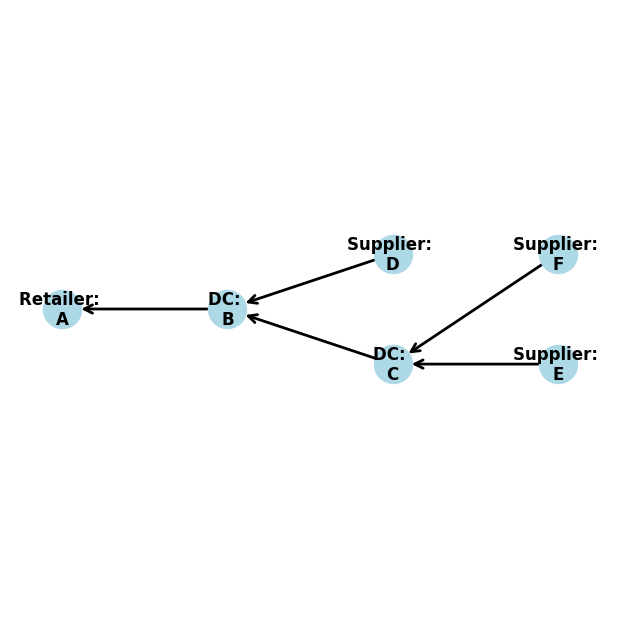

In [2]:
env = State()
env.create_state([-1, 0, 1, 1, 2, 2])
env.show_network()

In [3]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)

eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [4]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel3.pt"))
ppo_agent.policy.load_state_dict(torch.load(map_location=torch.device('cpu'),f="rlmodel3.pt"))

<All keys matched successfully>

In [5]:
#### Generate New Demand ####
demand_generator = GenerateDemandMonthly()

df = pd.read_csv("../src/TOTALSA.csv")
mean = df['TOTALSA'].mean()
std = df['TOTALSA'].std()
period = 108
iterations = 100

demand_matrix = np.reshape(demand_generator.simulate_normal_no_season(\
            periods = period * iterations, mean=mean, std=std),\
                (iterations, period))

In [6]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)
        

668.5999999999999
531.1999999999998
1110.8
802.3999999999999
760.3999999999999
937.1999999999998
1029.1999999999998
721.3999999999999
804.0
366.0
1017.8
1073.1999999999998
1089.1999999999998
510.5999999999999
765.3999999999999
830.0
969.5999999999999
908.5999999999999
1108.8
514.0
654.1999999999998
987.3999999999999
1064.6
-225.0
1865.3999999999996
650.3999999999999
900.1999999999998
213.5999999999999
650.0
880.8
739.3999999999999
998.5999999999999
733.8
1051.1999999999998
1070.1999999999998
697.0
653.0
736.3999999999999
971.1999999999998
1401.6
889.0
643.3999999999999
739.0
397.0
977.5999999999999
723.8
864.0
334.0
802.1999999999998
623.5999999999999
730.1999999999998
381.1999999999998
493.1999999999998
820.0
703.3999999999999
821.0
861.5999999999999
766.0
910.5999999999999
1233.3999999999999
758.8
972.0
1009.5999999999999
428.0
1225.1999999999998
154.0
1102.0
529.8
723.5999999999999
943.1999999999998
264.79999999999995
843.5999999999999
891.1999999999998
706.5999999999999
708.8
1366.

454.79999999999995
527.3999999999999
835.1999999999998
727.0
580.3999999999999
1110.6
541.8
667.3999999999999
953.5999999999999
1016.5999999999999
825.5999999999999
1033.6
989.5999999999999
1010.8
758.8
309.4
847.8
520.1999999999998
967.1999999999998
482.5999999999999
821.3999999999999
1071.1999999999998
450.0
719.0
756.1999999999998
178.5999999999999
607.0
717.5999999999999
774.0
779.3999999999999
807.3999999999999
755.5999999999999
298.5999999999999
792.8
851.1999999999998
650.3999999999999
829.1999999999998
821.1999999999998
643.5999999999999
691.0
964.1999999999998
1221.3999999999999
1026.1999999999998
507.79999999999995
454.0
1305.3999999999999
190.5999999999999
944.8
894.1999999999998
672.3999999999999
1223.1999999999998
506.79999999999995
1113.8
671.3999999999999
957.1999999999998
1012.1999999999998
828.0
1290.0
918.5999999999999
979.1999999999998
617.3999999999999
795.0
1155.8
569.8
387.0
671.3999999999999
475.79999999999995
814.5999999999999
970.5999999999999
776.8
921.3999999

In [7]:
print(reward_RL)

[84338.8, 82485.79999999997, 83026.60000000002, 79724.40000000001, 79310.00000000001, 82282.99999999999, 83183.59999999998, 79578.2, 79139.39999999997, 75552.19999999998, 81270.00000000001, 83721.40000000001, 79203.8, 82661.6, 82726.6, 79520.59999999995, 78218.39999999997, 83742.19999999997, 82913.0, 80037.39999999998, 79699.99999999997, 81457.2, 85059.20000000003, 83833.00000000003, 78261.59999999999, 81982.4, 80172.2, 82015.40000000004, 81874.0, 82673.79999999997, 79286.60000000002, 77551.99999999997, 81002.0, 80727.80000000003, 81599.80000000003, 79280.59999999996, 75021.19999999998, 80436.19999999997, 82948.39999999997, 84347.40000000002, 81670.79999999999, 80173.60000000003, 81603.6, 83127.00000000003, 80200.59999999998, 76683.40000000001, 87157.40000000007, 84081.99999999999, 78381.39999999997, 79438.59999999999, 81756.79999999999, 75601.6, 83067.20000000006, 77867.59999999999, 81964.59999999998, 78535.4, 73221.20000000001, 81254.60000000003, 83606.8, 75947.0, 82566.39999999997, 

In [8]:
## Starting inventory is fixed at 65
print(np.mean(reward_RL))

80526.94399999999


In [9]:
has_continuous_action_space = False # continuous action space; else discrete
action_std = 0.6            # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.03       # linearly decay action_std (action_std = action_std - action_std_decay_rate)
min_action_std = 0.03               # minimum action_std (stop decay after action_std <= min_action_std)
action_std_decay_freq = int(1e5)  # action_std decay frequency (in num timesteps
eps_clip = 0.2          # clip parameter for PPO
gamma = 0.99            # discount factor
K_epochs = 20
lr_actor = 0.00005      # learning rate for actor network
lr_critic = 0.0001       # learning rate for critic network

random_seed = 1234         # set random seed if required (0 = no random seed)

state_dim = 9
action_dim = 512

In [10]:
torch.manual_seed(random_seed)
np.random.seed(random_seed)

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
ppo_agent.policy_old.load_state_dict(torch.load("rlmodel3.pt"))
ppo_agent.policy.load_state_dict(torch.load("rlmodel3.pt"))

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
reward_RL = []

for demand_list in demand_matrix:
    reward_total = 0
    state = env.reset()
    env.set_demand_list(demand_list)
    done = False
    reward_sub = 0
    
    while not done:
        action = ppo_agent.select_action(state)
        state, reward, done = env.step(action)
        reward_sub += reward
        print(reward)
        if done:
            break
    reward_total += reward_sub
    reward_RL.append(reward_total)      


In [ ]:
#Starting inventory can be chosen by the RL
print(reward_RL)

In [ ]:
print(np.mean(reward_RL))

In [ ]:
reward_RL = []
for demand in demand_test:
    reward_total = 0
    for i in range(2):
        env = MultiEchelonInvOptEnv(demand[i*2:i*2+2])
        state = env.reset()
        done = False
        reward_sub = 0
        while not done:
            action = ppo_agent.select_action(state)
            state, reward, done = env.step(action)
            reward_sub += reward
            if done:
                break
        reward_total += reward_sub
    reward_RL.append(reward_total)